In [1]:
import numpy as np
import random 
import matplotlib.patches as mpatches
from matplotlib.pyplot import *

In [2]:
class Neuron:
    def __init__(self, type="excitatory", index=0, population=0):
        
        self.population = population
        self.index = index
        self.type = type
        self.time = 100
        self.steps = 0.25
        self.u_rest = 0
        self.threshold = 2 + random.random() * 2
        self.timer = np.arange(0, self.time + self.steps, self.steps)
        self.u = [self.u_rest] * len(self.timer)
        self.R = 10
        self.C = 5
        self.cons = self.R * self.C
        self.input_i = 0
        
    def update(self, j, input):
        self.u[j] += self.u[j-1] + (self.R * input - (self.u[j-1] - self.u_rest)) / self.cons * self.steps
        result = 0
        
        if self.u[j] >= self.threshold:
            result = self.threshold - self.u_rest
            self.u[j] = self.u_rest
        return result
            
    def reset(self, from_time):
        for i in range(from_time, len(self.timer)):
            self.u[i] = self.u_rest
            
    def update_u(self, value, j, pre_type):
        if (pre_type == "excitatory") and (self.type == "excitatory") or (pre_type == "inhibitory") and (self.type == "inhibitory"):
            self.u[j] += value
        else:
            self.u[j] -= value

In [3]:
class RandomInput:
    def __init__(self, i=1, step=100):
        self.last_i = 0
        self.i = i
        self.going_up = True
        self.step = step

    def get(self, iterate):
        if iterate % 20 == 0:
            self.going_up = not self.going_up
        temp = random.random()
        
        if self.going_up:
            temp = self.last_i + temp * (self.i/2)
        else:
            temp = self.last_i - temp * (self.i/2)
            
        if temp > self.i * 2 or temp < 0:
            temp = random.random() * self.i
        self.last_i = temp
        return temp

In [4]:
def connect(neuron1, neuron2, i_gen1=RandomInput(), i_gen2=RandomInput(), w=0.1, plot_title=None):
    input_neuron1 = [0] * len(neuron1.timer)
    input_neuron2 = [0] * len(neuron2.timer)
    
    for i in range(len(neuron1.timer)):
        current_i = i_gen1.get(i)
        input_neuron1[i] = current_i
        result = neuron1.update(j=i, input=current_i)
        
        if result > 0:
            neuron2.update_u(w * result, j=i, pre_type=neuron1.type)

    for i in range(len(neuron1.timer)):
        current_i = i_gen2.get(i)
        input_neuron2[i] = current_i
        result = neuron2.update(j=i, input=current_i)
        
        if result > 0:
            neuron1.update_u(w * result, j=i, pre_type=neuron2.type)
            neuron1.reset(i + 1)
            
            for update_time in range(i + 1, len(neuron1.timer)):
                neuron1.update(j=update_time, input=input_neuron1[update_time])
                
    fig = figure(num=None, figsize=(20, 10))
    fig.suptitle(plot_title, fontsize=14, fontweight='bold')
    
    subplot(221)
    plot(neuron1.timer, neuron1.u)
    ylabel('u')
    xlabel('time')
    title('Neuron 1: u - time Plot')
    grid(True)

    subplot(223)
    plot(neuron2.timer, neuron2.u)
    ylabel('u')
    xlabel('time')
    title('Neuron 2: u - time Plot')
    grid(True)

    subplot(222)
    plot(neuron1.timer, input_neuron1)
    ylabel('i')
    xlabel('time')
    title('Neuron 1: i - time Plot')
    grid(True)
    
    subplot(224)
    plot(neuron2.timer, input_neuron2)
    ylabel('i')
    xlabel('time')
    title('Neuron 2: i - time Plot')
    grid(True)

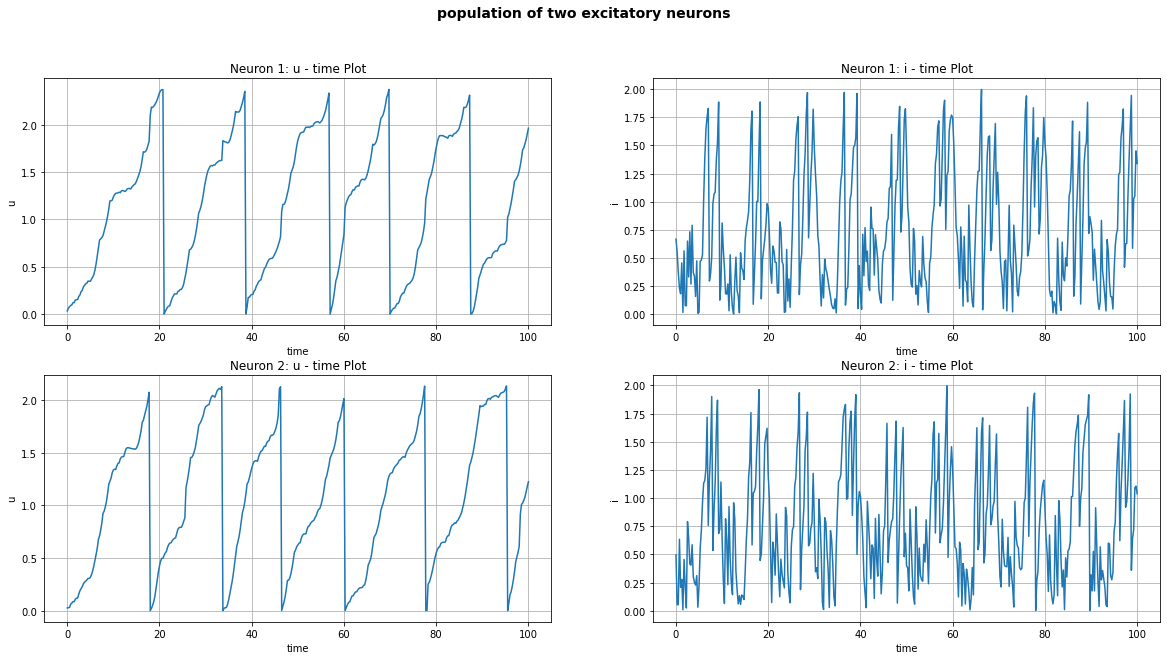

In [5]:
n1 = Neuron(type="excitatory", index=0)
n2 = Neuron(type="excitatory", index=1)

connect(n1, n2, plot_title="population of two excitatory neurons")

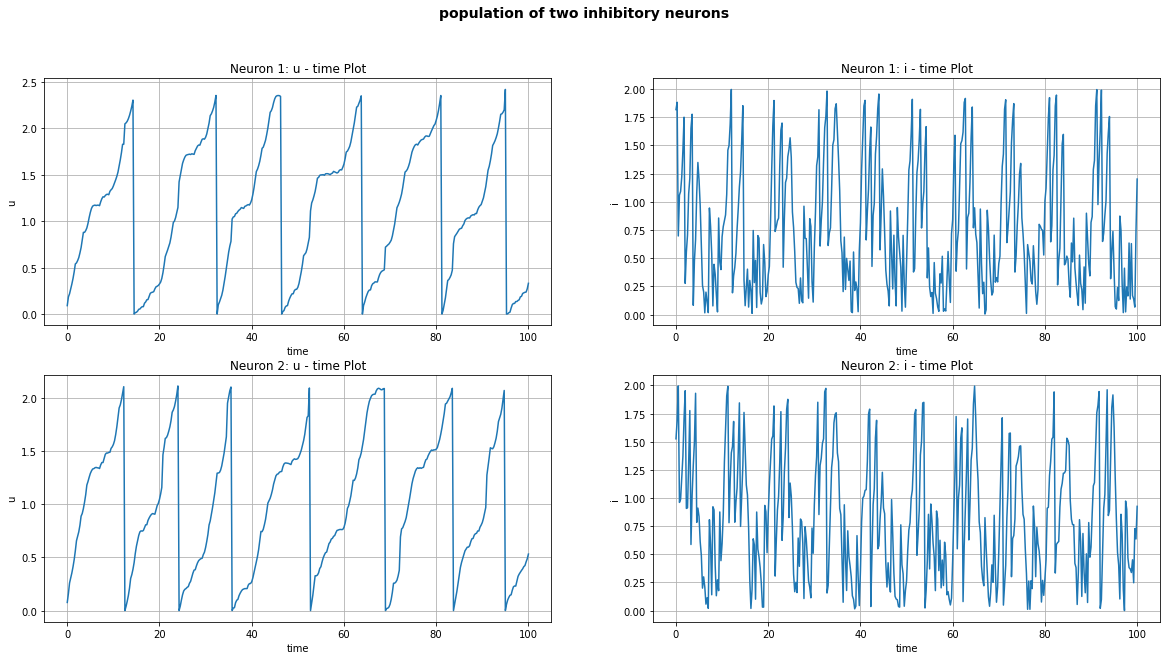

In [6]:
n1 = Neuron(type="inhibitory", index=0)
n2 = Neuron(type="inhibitory", index=1)

connect(n1, n2, plot_title="population of two inhibitory neurons")

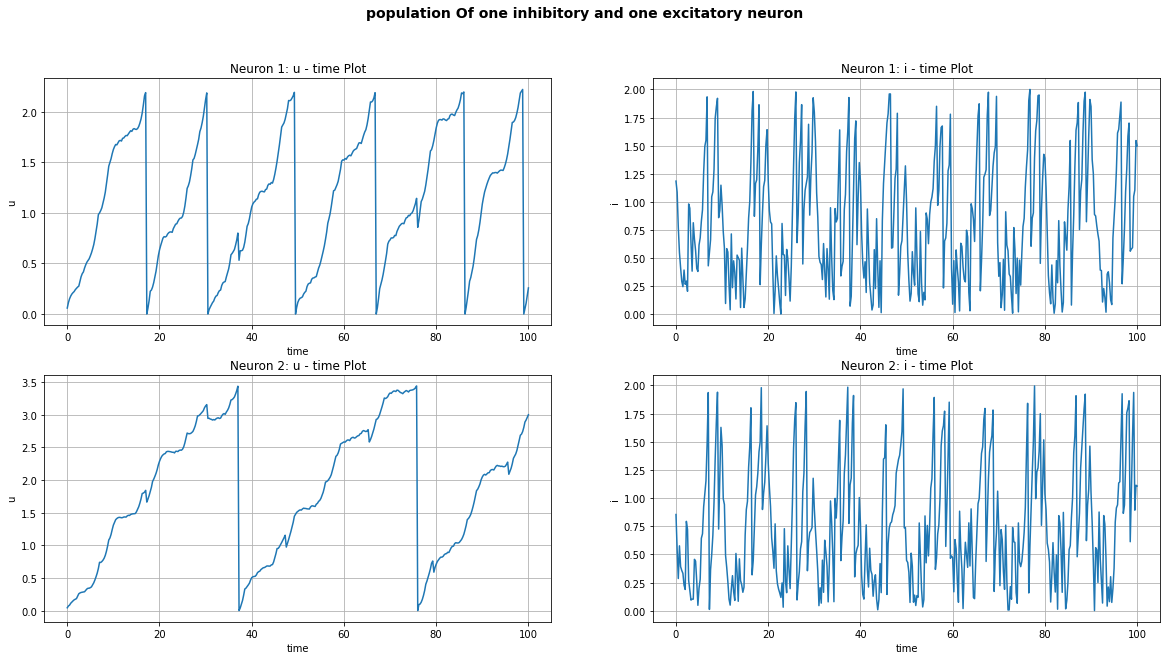

In [7]:
n1 = Neuron(type="inhibitory", index=0)
n2 = Neuron(type="excitatory", index=1)

connect(n1, n2, plot_title="population Of one inhibitory and one excitatory neuron")

In [8]:
class Population:
    def __init__(self, j_0=0.1, excitatory_Neuron=8, inhibitory_Neuron=2):
        self.excitatory_Neuron = excitatory_Neuron
        self.inhibitory_Neuron = inhibitory_Neuron
        self.N = inhibitory_Neuron + excitatory_Neuron
        self.w = j_0 / self.N
        self.population = []
        
    def activity(self, circle_size=2):
        c = 0
        
        for i in range(self.inhibitory_Neuron):
            self.population.append(Neuron(type="inhibitory", index=c))
            c += 1
            
        for i in range(self.excitatory_Neuron):
            self.population.append(Neuron(type="excitatory", index=c))
            c += 1

        y = [[-1 for x in range(self.N)] for y in range(len(self.population[0].timer))]

        i_gen = RandomInput()
        yi = [i_gen.get(i) for i in range(len(self.population[0].timer))]
        
        for i in (range(len(self.population[0].timer))):
            current_i = yi[i]
            
            for g in self.population:
                result = g.update(j=i, input=current_i)
                
                if result > 0:
                    y[i][g.index] = g.index
                    
                    for k in range(self.N):
                        self.population[k].update_u(self.w * result, j=i, pre_type=g.type)

        list1 = []
        for i in range(len(self.population[0].timer)):
            
            for g in range(self.N):
                
                if y[i][g] != -1:
                    list1.append((self.population[0].timer[i], y[i][g]))

        if len(list1) == 0:
            print("not single neurons fired")
        else:
            cdict = {1: 'red', 2: 'blue'}
            color = []
            fig = figure(num=None, figsize=(20, 20))
            fig.suptitle('population of ' + str(self.excitatory_Neuron) + " excitatory neurons and " + str(self.inhibitory_Neuron) + " inhibitory neurons", fontsize=22, fontweight='bold')
            ax = subplot(211)
            list1 = list(zip(*list1))

            c = ["b" if y >= self.excitatory_Neuron else "r" for y in list(list1[1])]

            scatter(list(list1[0]), list(list1[1]), c=c, s=circle_size)
            ylabel('population activity')
            xlabel('time')
            title('Raster Plot')
            
            red_patch = mpatches.Patch(color='red', label='excitatory neuron')
            blue_patch = mpatches.Patch(color='blue', label='inhibitory neuron')
            legend(handles=[red_patch, blue_patch])
            ax.set_xlim(xmin=0, xmax=self.population[0].time)
            grid(True)

            ax = subplot(212)
            plot(self.population[0].timer, yi)
            ylabel('input')
            xlabel('time')
            title('input - time plot')
            ax.set_xlim(xmin=0, xmax=self.population[0].time)
            grid(True)

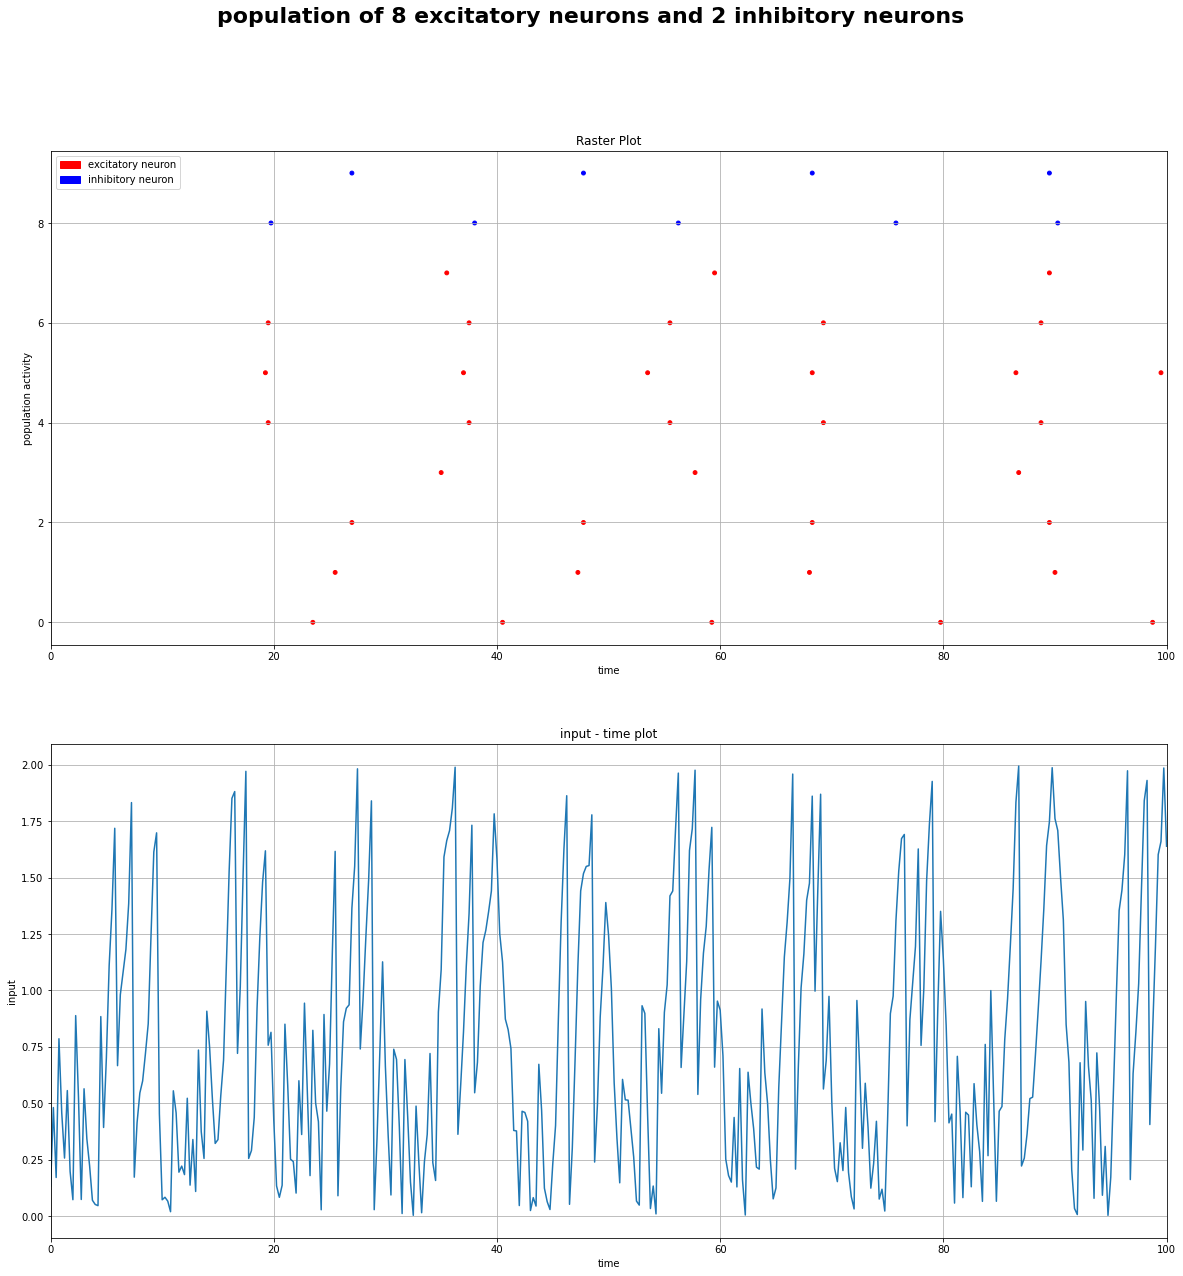

In [9]:
p = Population(excitatory_Neuron=8, inhibitory_Neuron=2)
p.activity(circle_size=15)

In [10]:
def three_populations(excitatory_N1, excitatory_N2, inhibitory_Neuron):
    
    N = excitatory_N1 + excitatory_N2 + inhibitory_Neuron
    group = []
    w = []
    c = 0
    
    for i in range(inhibitory_Neuron):
        group.append(Neuron(type="inhibitory", index=c, population=1))
        c += 1
        
    for i in range(excitatory_N1):
        group.append(Neuron(type="excitatory", index=c, population=2))
        c += 1
        
    for i in range(excitatory_N2):
        group.append(Neuron(type="excitatory", index=c, population=3))
        c += 1

    w = [[0 for _ in range(N)] for _ in range(N)]

    for i in range(inhibitory_Neuron):
        
        for j in range(inhibitory_Neuron):
            w[i][j] = 1 / inhibitory_Neuron
            
    for i in range(inhibitory_Neuron, inhibitory_Neuron + excitatory_N1):
        
        for j in range(inhibitory_Neuron, inhibitory_Neuron + excitatory_N1):
            w[i][j] = 1 / excitatory_N1
            
    for i in range(inhibitory_Neuron + excitatory_N1, inhibitory_Neuron + excitatory_N1 + excitatory_N2):
        
        for j in range(inhibitory_Neuron + excitatory_N1, inhibitory_Neuron + excitatory_N1 + excitatory_N2):
            w[i][j] = 1 / excitatory_N2

    w[excitatory_N1][0] = 0.04
    w[0][excitatory_N1] = 0.04
    w[excitatory_N1 + excitatory_N2][0] = 0.04
    w[0][excitatory_N1 + excitatory_N2] = 0.04


    y = [[-1 for x in range(N)] for y in range(len(group[0].timer))]
    yi = [0] * len(group[0].timer)
    Input_i = 1
    i_gen = RandomInput(i=Input_i, step=100)

    for i in (range(len(group[0].timer))):
        current_i = i_gen.get(i)
        yi[i] = current_i
        
        for g in group:
            
            if g.type == "inhibitory":
                current_i = 0.4
                
            if g.population == 2:
                current_i *= 1.02
            result = g.update(j=i, input=current_i)
            
            if result > 0:
                y[i][g.index] = g.index
                
                for k in range(N):
                    
                    if g.index != group[k].index:
                        group[k].update_u(w[g.index][k] * result, j=i, pre_type=g.type)
                        
    list1 = []
    for i in range(len(group[0].timer)):
        
        for g in range(N):
            
            if y[i][g] != -1:
                list1.append((group[0].timer[i], y[i][g]))
    if len(list1) == 0:
        print("not single neurons fired")

    cdict = {1: 'red', 2: 'blue', 3: "green"}
    color = []
    fig = figure(num=None, figsize=(20, 20))
    fig.suptitle('population of ' + str(excitatory_N1) + " ," +str(excitatory_N2) + " excitatory Neurons and " + str(inhibitory_Neuron) + " inhibitory Neurons", fontsize=22,fontweight='bold')
    ax = subplot(211)
    list1 = list(zip(*list1))

    c = []
    for y in list(list1[1]):
        if y < inhibitory_Neuron:
            c.append("g")
        if inhibitory_Neuron <= y < excitatory_N1 + inhibitory_Neuron:
            c.append("r")
        if y >= inhibitory_Neuron + excitatory_N1:
            c.append("b")

    scatter(list(list1[0]), list(list1[1]), marker='x', c=c, linewidths=3)
    ylabel('activity')
    xlabel('time')
    title('Raster Plot')
    
    red_patch = mpatches.Patch(color='red', label='excitatory neuron group 1')
    green_patch = mpatches.Patch(color='green', label='excitatory neuron group 2')
    blue_patch = mpatches.Patch(color='blue', label='inhibitory neuron')
    legend(handles=[red_patch, blue_patch, green_patch])
    ax.set_xlim(xmin=0, xmax=group[0].time)
    grid(True)

    ax = subplot(212)
    plot(group[0].timer, yi)
    ylabel('input')
    xlabel('time')
    title('input - time Plot')
    ax.set_xlim(xmin=0, xmax=group[0].time)
    grid(True)

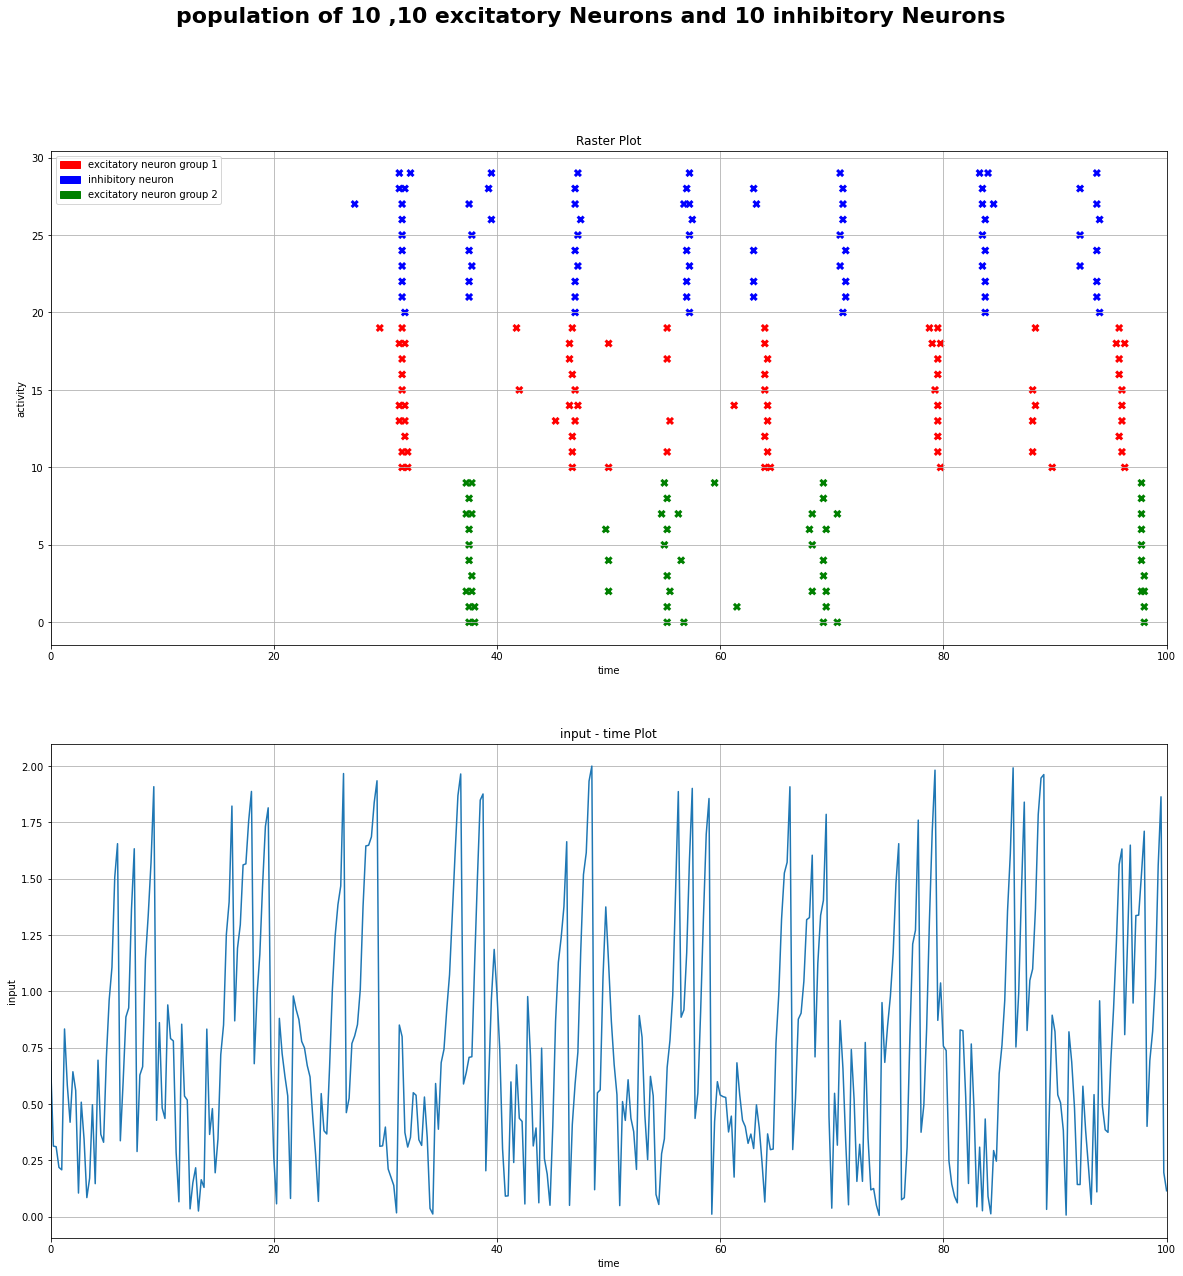

In [11]:
three_populations(10, 10, 10)